# 4. Evaluation Metrics for classification

## 4.1. Session review

Dataset : https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# %matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn =='yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state = 1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure','monthlycharges','totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod'
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2. Accuracy and dummy model

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).sum()

1132

In [11]:
1132 / 1409

0.8034066713981547

In [12]:
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print(f'{t:.2f} {score:.3f}')
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


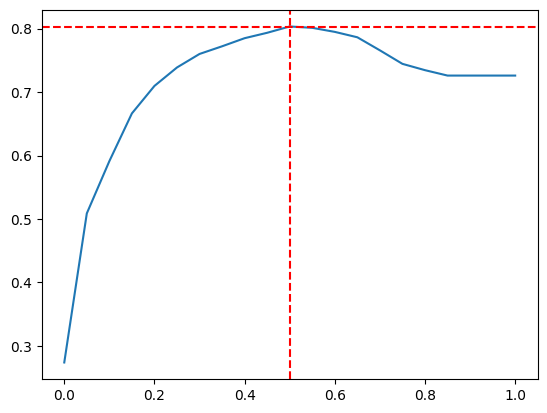

In [13]:
#Con 0.5 de threshold se obtiene un mejor score
plt.plot(thresholds, scores)
plt.axvline(0.5, color='r', linestyle= '--')
plt.axhline(0.803, color='r', linestyle= '--')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_val, y_pred >=0.5)

0.8034066713981547

In [17]:
from collections import Counter

In [19]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

## 4.3. Confusion table

In [20]:
actual_positive = (y_val== 1)
actual_negative = (y_val== 0)

In [21]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [22]:
TP = (predict_positive & actual_positive).sum()
TN = (predict_negative & actual_negative).sum()

In [23]:
FP = (predict_positive & actual_negative).sum()
FN = (predict_negative & actual_positive).sum()

In [24]:
TP, TN, FP, FN

(210, 922, 101, 176)

In [25]:
confusion_matrix = np.array([
    [TN,FP],
    [FN,TP]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [26]:
confusion_matrix = pd.DataFrame([[TN,FP],[FN,TP]])
confusion_matrix.columns = ['No_churn_predicted','Churn_predicted']
confusion_matrix.index = ['No_churn_real', 'churn_real']
confusion_matrix

,No_churn_predicted,Churn_predicted
No_churn_real,922,101
churn_real,176,210


## 4.4. Precision and Recall

In [27]:
accuracy_cm = (TP + TN) / (TP + TN + FP + FN)
accuracy_cm

0.8034066713981547

In [28]:
precision_cm = TP / (TP + FP)
precision_cm

0.6752411575562701

In [29]:
recall_cm = TP / (TP + FN)
recall_cm

0.5440414507772021

## 4.5. ROC Curves

In [30]:
tpr = TP / (TP + FN)
tpr

0.5440414507772021

In [31]:
fpr = FP / (FP + TN)
fpr

0.09872922776148582

In [32]:
scores = []
threshold = np.linspace(0,1,101)

for t in threshold:
    actual_positive = (y_val== 1)
    actual_negative = (y_val== 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn , tn))

In [33]:
columns  = ['thresholds', 'tp', 'fp', 'fn' , 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [34]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [35]:
df_scores.head(10)

,thresholds,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
5,0.05,379,685,7,338,0.981865,0.669599
6,0.06,377,661,9,362,0.976684,0.646139
7,0.07,372,641,14,382,0.963731,0.626588
8,0.08,371,613,15,410,0.961140,0.599218
9,0.09,369,580,17,443,0.955959,0.566960


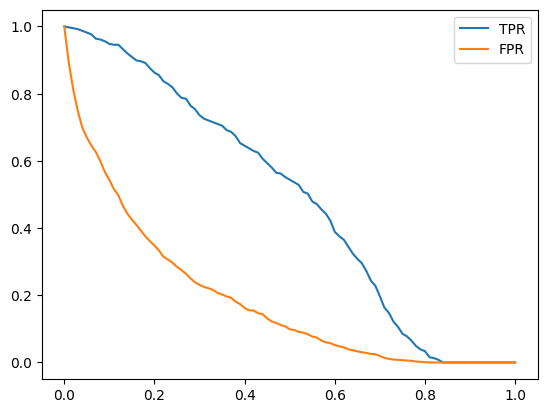

In [36]:
plt.plot(df_scores.thresholds, df_scores.tpr, label='TPR')
plt.plot(df_scores.thresholds, df_scores.fpr, label='FPR')
plt.legend()

### Random model

In [37]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size= len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [38]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [39]:
def tpr_fpr_dataframe(y_val,y_pred):
    scores = []
    threshold = np.linspace(0,1,101)

    for t in threshold:
        actual_positive = (y_val== 1)
        actual_negative = (y_val== 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn , tn))
    
    columns  = ['thresholds', 'tp', 'fp', 'fn' , 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [40]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand.head()

,thresholds,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,382,1013,4,10,0.989637,0.990225
2,0.02,379,993,7,30,0.981865,0.970674
3,0.03,375,979,11,44,0.971503,0.956989
4,0.04,372,969,14,54,0.963731,0.947214


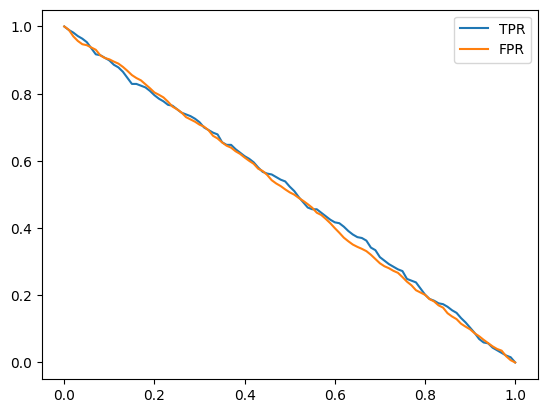

In [41]:
plt.plot(df_rand.thresholds, df_rand.tpr, label='TPR')
plt.plot(df_rand.thresholds, df_rand.fpr, label='FPR')
plt.legend()

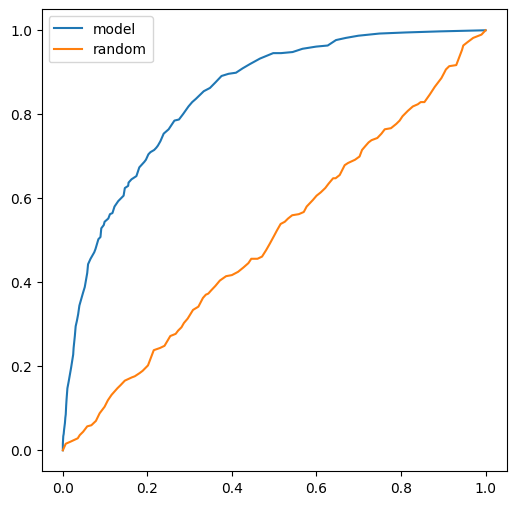

In [42]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')

plt.legend()

In [43]:
from sklearn.metrics import roc_curve

In [44]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

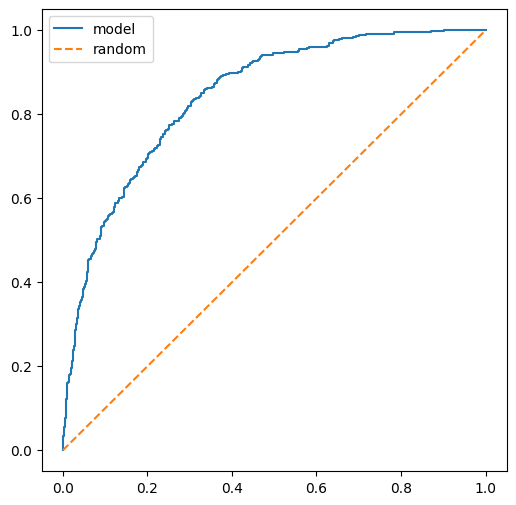

In [45]:
plt.figure(figsize=(6,6))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1],[0,1] , label='random', linestyle='--')

plt.legend()

## 4.6. ROC AUC

In [46]:
from sklearn.metrics import auc

In [47]:
auc(fpr, tpr)

0.8438479732980819

In [48]:
from sklearn.metrics import roc_auc_score

In [49]:
roc_auc_score(y_val,y_pred)

0.8438479732980819

In [50]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [51]:
import random

In [53]:
n = 100000
success = 0

for i in range(n):
        
    pos_ind = random.randint(0, len(pos)- 1)
    neg_ind = random.randint(0, len(neg)- 1)
    
    if pos[pos_ind]> neg[neg_ind]:
        success = success + 1

success / n

0.84335

## 4.7. Cross-Validation

In [54]:
def train(df,y, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient= 'records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [55]:
dv, model = train(df_train, y_train, C=0.001)

In [56]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X= dv.transform(dicts)

    y_pred= model.predict_proba(X)[:,1]

    return y_pred

In [57]:
y_pred = predict(df_val, dv, model)

In [58]:
from sklearn.model_selection import KFold

In [59]:
KFold= KFold(n_splits=10, shuffle=True, random_state=1)

In [62]:
from tqdm.auto import tqdm

c:\Users\daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
n_splits= 5

for C in tqdm([0.001,0.01,0.1,0.5,1,5,10]):

    scores = []

    for train_idx, val_idx in tqdm(KFold.split(df_full_train), total=n_splits):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model  = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print((C,np.mean(scores), np.std(scores)))

10it [00:04,  2.12it/s]0:00<?, ?it/s]
 14%|█▍        | 1/7 [00:04<00:28,  4.72s/it]

(0.001, 0.8262707367141304, 0.012398733515062208)


10it [00:04,  2.18it/s]
 29%|██▊       | 2/7 [00:09<00:23,  4.65s/it]

(0.01, 0.8406324699494713, 0.012152198358968863)


10it [00:04,  2.22it/s]
 43%|████▎     | 3/7 [00:13<00:18,  4.59s/it]

(0.1, 0.8408398051182508, 0.011812301811383524)


10it [00:05,  1.89it/s]
 57%|█████▋    | 4/7 [00:19<00:14,  4.87s/it]

(0.5, 0.8412939651084809, 0.011192764939551361)


10it [00:04,  2.14it/s]
 71%|███████▏  | 5/7 [00:23<00:09,  4.80s/it]

(1, 0.8400825299077349, 0.012699884136488798)


10it [00:05,  1.94it/s]
 86%|████████▌ | 6/7 [00:28<00:04,  4.92s/it]

(5, 0.8408626297673611, 0.011644703343400394)


10it [00:05,  1.95it/s]
100%|██████████| 7/7 [00:34<00:00,  4.87s/it]

(10, 0.8411631281002035, 0.011940735723037945)
